# Machine Learning Volatility Modeling
## Master's Thesis - Empirical Study 
### Università della Svizzera italiana

Pietro Bonazzi - pietro.bonazzi@usi.ch

Volatility Models - v.4

In [1]:
# Import packages 
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend 
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from scipy.stats import norm
from dieboldmariano import dm_test
from xgboost import XGBRegressor

### Data Preparation

In [3]:
def prepare_data(data_stock, mkt_covariates, lags_RV = [1,5,22], lags_RQ = [1,5,22], RQ_add = True):
    '''
    This function prepares the data for the model.

    Parameters
    ----------
    data_stock : DataFrame
        DataFrame containing the stock data.
    mkt_covariates : DataFrame
        DataFrame containing the market covariates.
    lags_RV : list, optional
        List of lags for the realized variance. The default is [1,5,22].
    lags_RQ : list, optional    
        List of lags for the realized quarticity. The default is [1,5,22].
    RQ_add : bool, optional
        Boolean to decide whether to add the realized quarticity. The default is True.
    '''

    data_stock.index = pd.to_datetime(data_stock.index)
    data_stock['RV_'+  str(lags_RV[0])] = data_stock['RV'].rolling(window=lags_RV[0]).mean()
    data_stock['RV_'+  str(lags_RV[1])] = data_stock['RV_'+  str(lags_RV[0])].rolling(window=lags_RV[1]).mean()
    data_stock['RV_'+  str(lags_RV[2])] = data_stock['RV_'+  str(lags_RV[0])].rolling(window=lags_RV[2]).mean()

    if RQ_add == True: 
        data_stock['RQ_'+  str(lags_RQ[0])] = data_stock['RQ'].rolling(window=lags_RQ[0]).mean()
        data_stock['RQ_'+  str(lags_RQ[1])] = data_stock['RQ_'+  str(lags_RQ[0])].rolling(window=lags_RQ[1]).mean()
        data_stock['RQ_'+  str(lags_RQ[2])] = data_stock['RQ_'+  str(lags_RQ[0])].rolling(window=lags_RQ[2]).mean()

    mkt_covariates.index = pd.to_datetime(mkt_covariates.index)
    mkt_covariates['CHFUSD'] = mkt_covariates['CHFUSD'].pct_change()
    mkt_covariates['CHFEUR'] = mkt_covariates['CHFEUR'].pct_change()
    mkt_covariates['GSWISS10'] = mkt_covariates['GSWISS10'].diff()
    mkt_covariates['CCFASZE'] = mkt_covariates['CCFASZE'].diff()
    mkt_covariates['SFSNTC'] = mkt_covariates['SFSNTC'].diff()
    mkt_covariates['SSARON'] = mkt_covariates['SSARON'].diff()
    mkt_covariates = mkt_covariates[30:-1]

    data = pd.concat([data_stock, mkt_covariates], axis=1, join='inner')
    data['Returns'] = data['Returns'].shift(-1)
    data['RV'] = data['RV'].shift(-1)
    data['RQ'] = data['RQ'].shift(-1)
    data.dropna(inplace=True)
    data = pd.DataFrame(data)
    
    return data

In [9]:
def create_df_selected_features(data, features):

    # Select the features
    select_features = ['Returns', 'RV'] + features
    data = data[select_features]

    # Define the train, validation and test dates
    train_date = data.index[int(len(data)*0.6)] # 60% of the data
    test_date = data.index[-1] # 30% of the data

    # Split the data into train and test
    df_train = data.loc[:train_date]
    df_test = data.loc[train_date:]
    df_test = df_test.drop(df_test.index[0])

    return df_train, df_test

In [5]:
# Import data for testing
conn = sqlite3.connect('data.db')
df_stock = pd.read_sql_query("SELECT * FROM GIVN", conn).set_index('date')
df_mkt = pd.read_sql_query("SELECT * FROM mkt_covariates", conn).set_index('date')
all_features = [df_stock.columns, df_mkt.columns]
all_features

[Index(['Returns', 'RV', 'RQ', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
        'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL',
        'NEWS_SENTIMENT_DAILY_AVG'],
       dtype='object'),
 Index(['VSMI', 'CHFEUR', 'CHFUSD', 'SFSNTC', 'GSWISS10', 'CCFASZE', 'SSARON',
        'EURCHFV3M', 'USDCHFV3M'],
       dtype='object')]

In [6]:
# Prepare data
data = prepare_data(df_stock, df_mkt, lags_RV = [1,5,22], lags_RQ = [1,5,22], RQ_add = True)

## HAR 

### HAR Benchmark

In [7]:
def har_bmk (df_train, df_test, plot = False):

    '''
    HAR benchmark model. Default RV lags are 1, 5 and 22.

    Parameters
    ----------
    df_train : pandas.DataFrame
        Train data.
    df_test : pandas.DataFrame
        Test data.
    plot : bool, optional

    '''

    model = LinearRegression()

    # Fit the model
    model.fit(df_train.drop(['Returns', 'RV'], axis=1), df_train['RV'])
    prediction_bmk = model.predict(df_test.drop(['Returns', 'RV'], axis=1))

    # Calculate the RMSE
    rmse = np.sqrt(mse(df_test['RV'], prediction_bmk))
    
    results_bmk = pd.DataFrame({'pred_bmk': prediction_bmk, 'RV': df_test['RV']})
    results_bmk.index = df_test.index


    # Calculate the violation ratio
    alpha = 0.05
    var = pd.DataFrame({'VAR': results_bmk['pred_bmk']* norm.ppf(alpha), 'Returns': df_test['Returns']})
    violation_ratio = (var['Returns'] < var['VAR']).sum()/len(df_test)

    #DMW test (not necessary for benchmark model)
    dmw_test = (0,0)

    if plot is True:
        plt.rcParams["font.family"] = "Times New Roman"
        fig, ax = plt.subplots(figsize=(11, 3))
        ax.plot(results_bmk['pred_bmk'], label='prediction', color='black', linewidth=0.9)
        ax.plot(results_bmk['RV'], label='RV', color='grey', linewidth=0.7)
        ax.set_title('HAR_benchmark')   
        ax.legend(loc='upper left')
        ax.set_xlabel('Date')
        ax.xaxis.set_major_locator(plt.MaxNLocator(6))
        plt.show()
    

    return rmse, violation_ratio, dmw_test, results_bmk

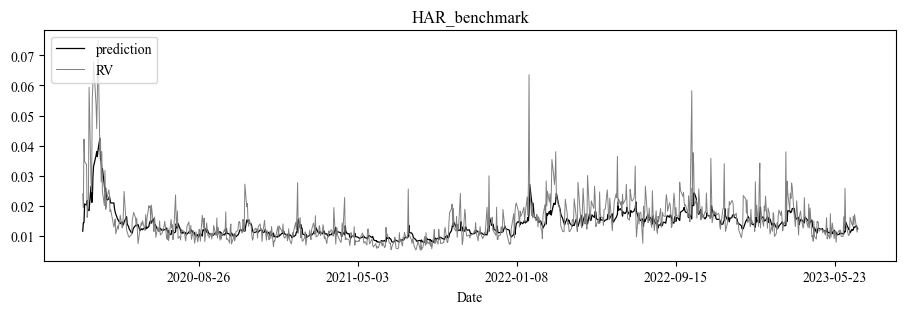

(0.0058023309137736675,
 0.06398104265402843,
 (0, 0),
             pred_bmk        RV
 date                          
 2020-02-25  0.011534  0.023963
 2020-02-26  0.014308  0.019357
 2020-02-27  0.014379  0.042140
 2020-02-28  0.020594  0.034632
 2020-03-02  0.020250  0.033767
 ...              ...       ...
 2023-06-22  0.012956  0.013675
 2023-06-23  0.012735  0.017092
 2023-06-26  0.013414  0.012607
 2023-06-27  0.012607  0.011210
 2023-06-28  0.012271  0.012289
 
 [844 rows x 2 columns])

In [10]:
#### Test function ####

# Select features
features = ['RV_1', 'RV_5', 'RV_22']
df_train, df_test = create_df_selected_features (data, features)

# Results
rmse, violation_ratio, dmw_test, results_bmk = har_bmk (df_train=df_train, df_test=df_test, plot = True)
rmse, violation_ratio, dmw_test, results_bmk

In [39]:
def har_regularized(df_train, df_test, results_bmk, regularization = 'Lasso', plot = False):
    '''
    HAR regularized model. Default RV lags are 1, 5 and 22.
    
    Parameters
    ----------
    df_train : pandas.DataFrame
        Train data.
    df_test : pandas.DataFrame
        Test data.
    results_bmk : pandas.DataFrame
        Results of the HAR benchmark model.
    regularization : str, optional
        Regularization method. The default is 'Lasso'.
    plot : bool, optional
    
    '''

    # Define type of model
    if regularization == 'Lasso':
        model = LassoCV() # Lasso linear regression with built-in cross-validation of the alpha parameter
    elif regularization == 'Ridge':
        model = RidgeCV()
    elif regularization == 'ElasticNet':
        model = ElasticNetCV()


    # Fit the model
    model.fit(df_train.drop(['Returns', 'RV'], axis=1), df_train['RV'])
    prediction = model.predict(df_test.drop(['Returns', 'RV'], axis=1))

    # Calculate the RMSE
    rmse = np.sqrt(mse(df_test['RV'], prediction))
    
    results = pd.DataFrame({'pred': prediction, 'RV': df_test['RV']})
    results.index = df_test.index

    # Calculate the violation ratio
    alpha = 0.05
    var = pd.DataFrame({'VAR': results['pred']* norm.ppf(alpha), 'Returns': df_test['Returns']})
    violation_ratio = (var['Returns'] < var['VAR']).sum()/len(df_test)


    # Calculate the Diebold-Mariano test
    df_dmw_test = pd.concat([results_bmk['pred_bmk'], results['pred'], df_test['RV']], axis=1)
    dmw_test = dm_test(df_dmw_test['RV'], df_dmw_test['pred_bmk'], df_dmw_test['pred'], one_sided=True)

    if plot is True:
        plt.rcParams["font.family"] = "Times New Roman"
        fig, ax = plt.subplots(figsize=(11, 3))
        ax.plot(results['pred'], label='prediction', color='black', linewidth=0.9)
        ax.plot(results['RV'], label='RV', color='grey', linewidth=0.7)
        ax.set_title('HAR_' + regularization)   
        ax.legend(loc='upper left')
        ax.set_xlabel('Date')
        ax.xaxis.set_major_locator(plt.MaxNLocator(6))
        plt.show()
    

    return rmse, violation_ratio, dmw_test

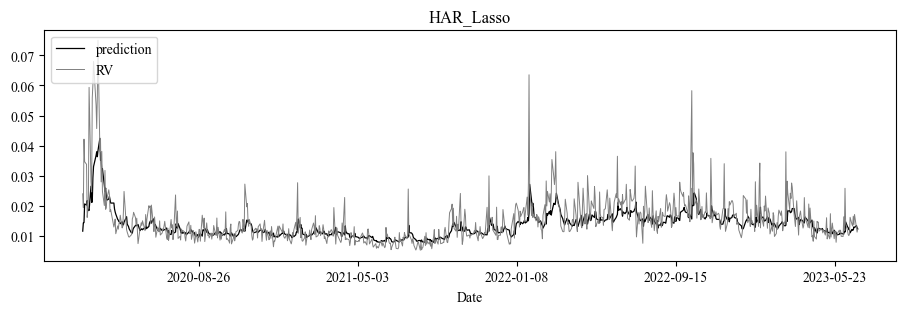

(0.0058047396918911335,
 0.06398104265402843,
 (-4.939839202001016, 4.714629014776813e-07))

In [41]:
#### Test function ####

# Select features
features = ['RV_1', 'RV_5', 'RV_22']

df_train, df_test = create_df_selected_features (data, features)

# Test function
rmse, violation_ratio, dmw_test = har_regularized(df_train=df_train, df_test=df_test, results_bmk=results_bmk, regularization = 'Lasso', plot = True)
rmse, violation_ratio, dmw_test

## LSTM
### LSTM Single Layer

In [28]:
# Function to prepare the data for the LSTM model 
def windowed_dataset(x_series, y_series, n_past):
    dataX, dataY = [], []
    for i in range((n_past-1), len(x_series)):
        start_idx = x_series.index[i-n_past+1]
        end_idx = x_series.index[i]
        a = x_series[start_idx:end_idx].values
        dataX.append(a)
        dataY.append(y_series[end_idx])
    return np.array(dataX), np.array(dataY)

In [29]:
def lstm_single_layer(df_train, df_test, results_bmk, neurons = '20', n_past = '22', batch_size = '32', plot = False): 

    '''
    LSTM single layer model.

    Parameters
    ----------
    df_train : pandas.DataFrame
        Train data.
    df_test : pandas.DataFrame
        Test data.
    results_bmk : pandas.DataFrame  
        Results of the HAR benchmark model.
    neurons : str, optional
        Number of neurons in the LSTM layer. The default is '20'.
    n_past : str, optional
        Number of past observations to use as input. The default is '22'.
    batch_size : str, optional
        Batch size. The default is '32'.
    plot : bool, optional   
    '''


    np.random.seed(2024)
    n_dims = df_train.shape[1]-2
    x_train, y_train = windowed_dataset(df_train.drop(['Returns', 'RV'], axis=1), df_train['RV'], n_past)

    # Define the model
    lstm = tf.keras.models.Sequential([ 
        tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),

        tf.keras.layers.LSTM(neurons),
        
        tf.keras.layers.Dense(1)
    ])
    
    def rmse(y_true, y_pred):
        loss = backend.sqrt(backend.mean(backend.square((y_true - y_pred))))
        return loss

    lstm.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmse])
    
    checkpoint_cb = ModelCheckpoint('NN_models/lstm_single_layer.h5',
                                save_best_only=True,
                                monitor='val_rmse')

    early_stopping_cb = EarlyStopping(patience=100,
                                  restore_best_weights=True,
                                  monitor='val_rmse')
    
    lstm_res = lstm.fit(x_train, y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.3, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=300)
    
    x_test, y_test = windowed_dataset(df_test.drop(['Returns', 'RV'], axis=1), df_test['RV'], n_past)
    x, returns = windowed_dataset(df_test.drop(['Returns', 'RV'], axis=1), df_test['Returns'], n_past)

    # Predictions
    pred = lstm.predict(x_test)
    df_results = pd.DataFrame({'RV': y_test, 'pred': pred.flatten(), 'returns': returns})
    df_results.index = df_test.index[n_past-1:]

    # Calculate the RMSE
    rmse = np.sqrt(mse(df_results['RV'], df_results['pred']))

    # Calculate the violation ratio
    alpha = 0.05
    var = pd.DataFrame({'VAR': df_results['pred']* norm.ppf(alpha), 'Returns': df_results['returns']})
    violation_ratio = (var['Returns'] < var['VAR']).sum()/len(df_results)

    # Calculate the Diebold-Mariano test
    df_dmw_test = pd.concat([results_bmk['pred_bmk'], df_results['pred'], df_results['RV']], axis=1).dropna()
    dmw_test = dm_test(df_dmw_test['RV'], df_dmw_test['pred_bmk'], df_dmw_test['pred'], one_sided=True)

    if plot == True:
        plt.rcParams["font.family"] = "Times New Roman"
        fig, ax = plt.subplots(figsize=(11, 3))
        ax.plot(df_results['pred'], label='prediction', color='black', linewidth=0.9)
        ax.plot(df_results['RV'], label='RV', color='grey', linewidth=0.7)
        ax.set_title('LSTM_single_layer')   
        ax.legend(loc='upper left')
        ax.set_xlabel('Date')
        ax.xaxis.set_major_locator(plt.MaxNLocator(6))
        plt.show()

    return rmse, violation_ratio, dmw_test

/Users/pietrobonazzi/miniconda3/envs/Python_Thesis_Env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 0s 1ms/step


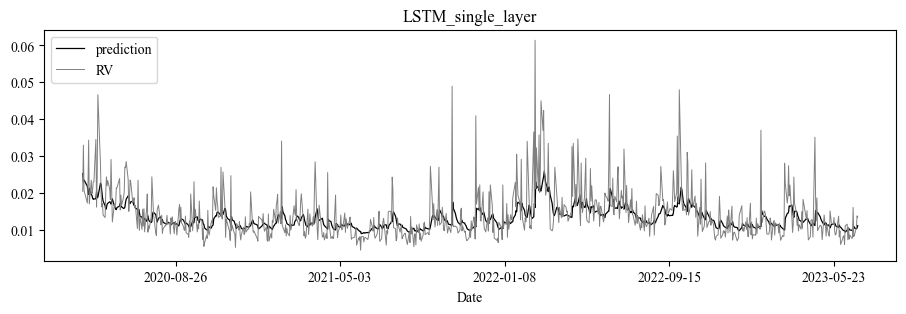

(0.005785811029971464,
 0.05889570552147239,
 (-1.4676754928048452, 0.0712893307583718))

In [21]:
#### Test function ####

# Select features
features = ['RV_1', 'RQ_1']

df_train, df_test = create_df_selected_features (data, features)

# Test function
rmse, violation_ratio, dmw_test = lstm_single_layer(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                     neurons = 25, n_past = 30, batch_size = 32, plot = True)
rmse, violation_ratio, dmw_test

/Users/pietrobonazzi/miniconda3/envs/Python_Thesis_Env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 0s 1ms/step


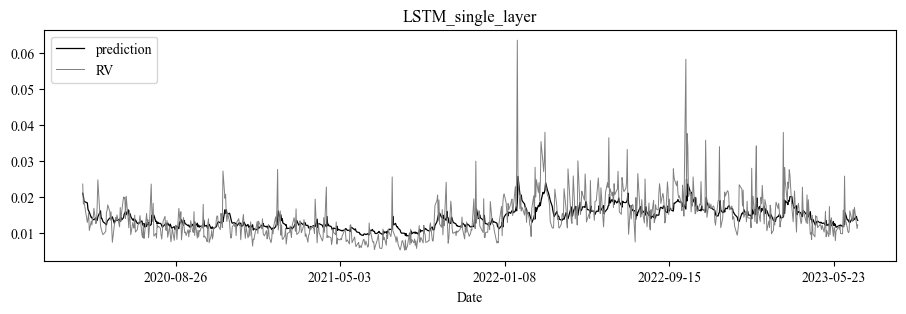

(0.00480737344919079,
 0.053987730061349694,
 (2.2745876895620354, 0.9884049664394469))

In [42]:
#### Test function ####

# Select features
features = ['RV_1']

df_train, df_test = create_df_selected_features (data, features)

# Test function
rmse, violation_ratio, dmw_test = lstm_single_layer(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                     neurons = 25, n_past = 30, batch_size = 3, plot = True)
rmse, violation_ratio, dmw_test

/Users/pietrobonazzi/miniconda3/envs/Python_Thesis_Env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 0s 2ms/step


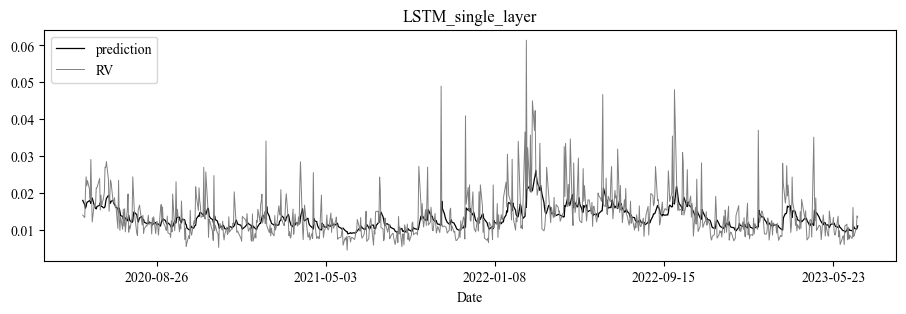

(0.005668450606340131,
 0.05660377358490566,
 (-1.793458540937198, 0.036640040449622484))

In [30]:
#### Test function ####

# Select features
features = ['RV_1']

df_train, df_test = create_df_selected_features (data, features)

# Test function
rmse, violation_ratio, dmw_test = lstm_single_layer(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                     neurons = 25, n_past = 50, batch_size = 32, plot = True)
rmse, violation_ratio, dmw_test

### LSTM 2-layers with dropout

In [20]:
def lstm_2_layers_with_dropout(df_train, df_test, results_bmk, neurons = [32,16], n_past = 22, batch_size = 32, dropout = 0.1, plot = False): 

    '''
    LSTM 2 layers with dropout model.

    Parameters
    ----------
    df_train : pandas.DataFrame
        Train data.
    df_test : pandas.DataFrame
        Test data.
    results_bmk : pandas.DataFrame
        Results of the HAR benchmark model.
    neurons : list, optional
        Number of neurons in the LSTM layers. The default is [32,16].
    n_past : int, optional
        Number of past observations to use as input. The default is 22.
    batch_size : int, optional
        Batch size. The default is 32.
    dropout : float, optional
        Dropout rate. The default is 0.1.
    plot : bool, optional
    '''

    np.random.seed(2024)
    n_dims = df_train.shape[1]-2
    x_train, y_train = windowed_dataset(df_train.drop(['Returns', 'RV'], axis=1), df_train['RV'], n_past)

    lstm = tf.keras.models.Sequential([ 
        tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
        tf.keras.layers.BatchNormalization(), 

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons[0], return_sequences=True)),
        tf.keras.layers.Dropout(dropout),

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons[1])),
        tf.keras.layers.Dropout(dropout),

        tf.keras.layers.Dense(1)
    ])
    
    def rmse(y_true, y_pred):
        loss = backend.sqrt(backend.mean(backend.square((y_true - y_pred))))
        return loss

    lstm.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmse])
    
    checkpoint_cb = ModelCheckpoint('NN_models/lstm_2_layers_with_dropout.h5',
                                save_best_only=True,
                                monitor='val_rmse')

    early_stopping_cb = EarlyStopping(patience=100,
                                  restore_best_weights=True,
                                  monitor='val_rmse')
    
    lstm_res = lstm.fit(x_train, y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.3, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=300)
    
    x_test, y_test = windowed_dataset(df_test.drop(['Returns', 'RV'], axis=1), df_test['RV'], n_past)
    x, returns = windowed_dataset(df_test.drop(['Returns', 'RV'], axis=1), df_test['Returns'], n_past)

    # Predictions
    pred = lstm.predict(x_test)
    df_results = pd.DataFrame({'RV': y_test, 'pred': pred.flatten(), 'returns': returns})
    df_results.index = df_test.index[n_past-1:]

    # Calculate the RMSE
    rmse = np.sqrt(mse(df_results['RV'], df_results['pred']))

    # Calculate the violation ratio
    alpha = 0.05
    var = pd.DataFrame({'VAR': df_results['pred']* norm.ppf(alpha), 'Returns': df_results['returns']})
    violation_ratio = (var['Returns'] < var['VAR']).sum()/len(df_results)

    # Calculate the Diebold-Mariano test
    df_dmw_test = pd.concat([results_bmk['pred_bmk'], df_results['pred'], df_results['RV']], axis=1).dropna()
    dmw_test = dm_test(df_dmw_test['RV'], df_dmw_test['pred_bmk'], df_dmw_test['pred'], one_sided=True)

    if plot == True:
        plt.rcParams["font.family"] = "Times New Roman"
        fig, ax = plt.subplots(figsize=(11, 3))
        ax.plot(df_results['pred'], label='prediction', color='black', linewidth=0.9)
        ax.plot(df_results['RV'], label='RV', color='grey', linewidth=0.7)
        ax.set_title('LSTM_2_layers_with_dropout') 
        ax.legend(loc='upper left')
        ax.set_xlabel('Date')
        ax.xaxis.set_major_locator(plt.MaxNLocator(6))
        plt.show()

    return rmse, violation_ratio, dmw_test

/Users/pietrobonazzi/miniconda3/envs/Python_Thesis_Env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 1s 3ms/step


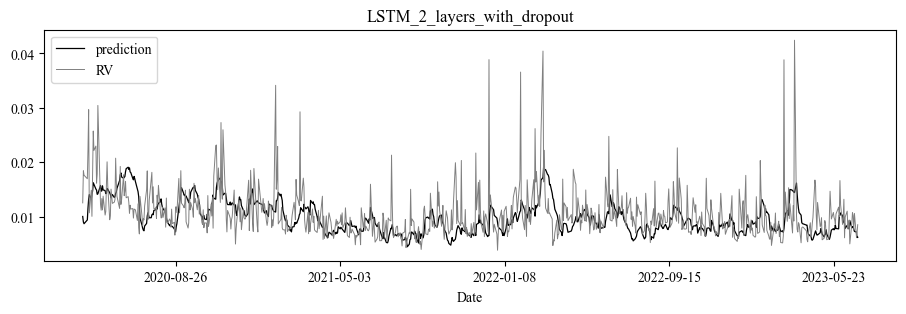

(0.004466693699911819,
 0.06993865030674846,
 (-4.373790895704036, 6.898007755426935e-06))

In [21]:
#### Test function ####

# Select features
features = ['RV_1', 'RQ_1', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
        'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL',
        'NEWS_SENTIMENT_DAILY_AVG']

df_train, df_test = create_df_selected_features (data, features)

# Test function
rmse, violation_ratio, dmw_test = lstm_2_layers_with_dropout(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                     neurons = [32,32], n_past = 30, batch_size = 32, dropout=0.1, plot = True)
rmse, violation_ratio, dmw_test

/Users/pietrobonazzi/miniconda3/envs/Python_Thesis_Env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 1s 3ms/step


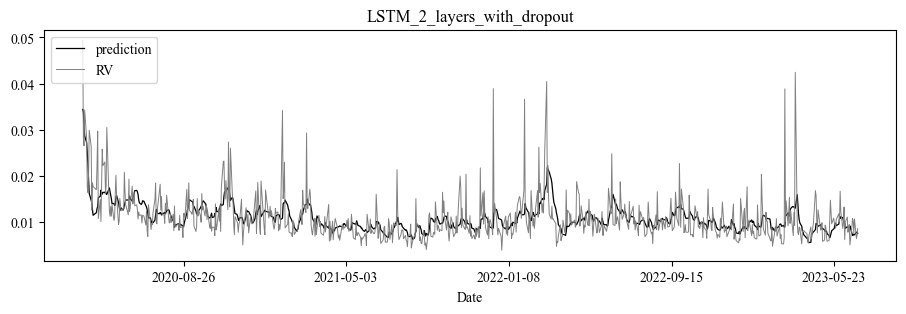

(0.004115608125947986,
 0.05333333333333334,
 (0.463302301086459, 0.6783649802524274))

In [22]:
#### Test function ####

# Select features
features = ['RV_1', 'RQ_1', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
        'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL']

df_train, df_test = create_df_selected_features (data, features)

# Test function
rmse, violation_ratio, dmw_test = lstm_2_layers_with_dropout(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                     neurons = [32,32], n_past = 20, batch_size = 16, dropout=0.1, plot = True)
rmse, violation_ratio, dmw_test

/Users/pietrobonazzi/miniconda3/envs/Python_Thesis_Env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 1s 3ms/step


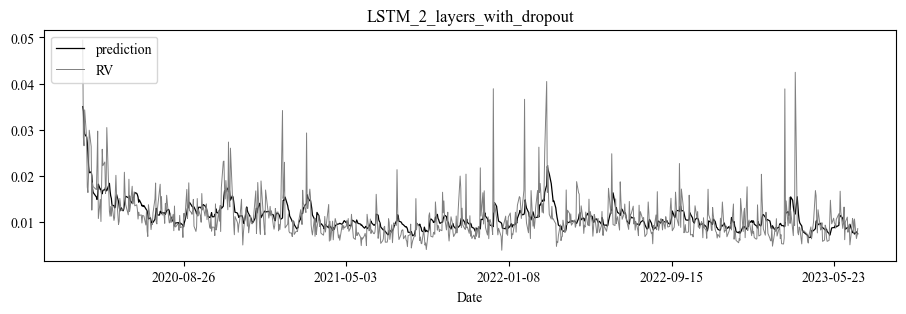

(0.00408472390032723,
 0.052121212121212124,
 (1.2527923399483756, 0.8946816508219624))

In [23]:
#### Test function ####

# Select features
features = ['RV_1', 'RQ_1', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
        'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL']

df_train, df_test = create_df_selected_features (data, features)

# Test function
rmse, violation_ratio, dmw_test = lstm_2_layers_with_dropout(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                     neurons = [32,32], n_past = 20, batch_size = 8, dropout=0.1, plot = True)
rmse, violation_ratio, dmw_test

In [25]:
def lstm_3_layers_with_dropout(df_train, df_test, results_bmk, neurons = [32,16,8], n_past = 22, batch_size = 32, dropout = 0.1, plot = False): 

    '''
    LSTM 3 layers with dropout model.

    Parameters
    ----------
    df_train : pandas.DataFrame
        Train data.
    df_test : pandas.DataFrame
        Test data.
    results_bmk : pandas.DataFrame
        Results of the HAR benchmark model.
    neurons : list, optional    
        Number of neurons in the LSTM layers. The default is [32,16,8].
    n_past : int, optional  
        Number of past observations to use as input. The default is 22. 
    batch_size : int, optional  
        Batch size. The default is 32.  
    dropout : float, optional
        Dropout rate. The default is 0.1.
    plot : bool, optional
    '''

    np.random.seed(2024)
    n_dims = df_train.shape[1]-2
    x_train, y_train = windowed_dataset(df_train.drop(['Returns', 'RV'], axis=1), df_train['RV'], n_past)

    lstm = tf.keras.models.Sequential([ 
        tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
        tf.keras.layers.BatchNormalization(), 

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons[0], return_sequences=True)),
        tf.keras.layers.Dropout(dropout),

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons[1], return_sequences=True)),
        tf.keras.layers.Dropout(dropout),

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons[2])),
        tf.keras.layers.Dropout(dropout),

        tf.keras.layers.Dense(1)
    ])
    
    def rmse(y_true, y_pred):
        loss = backend.sqrt(backend.mean(backend.square((y_true - y_pred))))
        return loss

    lstm.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmse])
    
    checkpoint_cb = ModelCheckpoint('NN_models/lstm_2_layers_with_dropout.h5',
                                save_best_only=True,
                                monitor='val_rmse')

    early_stopping_cb = EarlyStopping(patience=50,
                                  restore_best_weights=True,
                                  monitor='val_rmse')
    
    lstm_res = lstm.fit(x_train, y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.3, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=300)
    
    x_test, y_test = windowed_dataset(df_test.drop(['Returns', 'RV'], axis=1), df_test['RV'], n_past)
    x, returns = windowed_dataset(df_test.drop(['Returns', 'RV'], axis=1), df_test['Returns'], n_past)

    # Predictions
    pred = lstm.predict(x_test)
    df_results = pd.DataFrame({'RV': y_test, 'pred': pred.flatten(), 'returns': returns})
    df_results.index = df_test.index[n_past-1:]

    # Calculate the RMSE
    rmse = np.sqrt(mse(df_results['RV'], df_results['pred']))

    # Calculate the violation ratio
    alpha = 0.05
    var = pd.DataFrame({'VAR': df_results['pred']* norm.ppf(alpha), 'Returns': df_results['returns']})
    violation_ratio = (var['Returns'] < var['VAR']).sum()/len(df_results)

    # Calculate the Diebold-Mariano test
    df_dmw_test = pd.concat([results_bmk['pred_bmk'], df_results['pred'], df_results['RV']], axis=1).dropna()
    dmw_test = dm_test(df_dmw_test['RV'], df_dmw_test['pred_bmk'], df_dmw_test['pred'], one_sided=True)

    if plot == True:
        plt.rcParams["font.family"] = "Times New Roman"
        fig, ax = plt.subplots(figsize=(11, 3))
        ax.plot(df_results['pred'], label='prediction', color='black', linewidth=0.9)
        ax.plot(df_results['RV'], label='RV', color='grey', linewidth=0.7)
        ax.set_title('LSTM_3_layers_with_dropout') 
        ax.legend(loc='upper left')
        ax.set_xlabel('Date')
        ax.xaxis.set_major_locator(plt.MaxNLocator(6))
        plt.show()

    return rmse, violation_ratio, dmw_test

/Users/pietrobonazzi/miniconda3/envs/Python_Thesis_Env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 1s 8ms/step


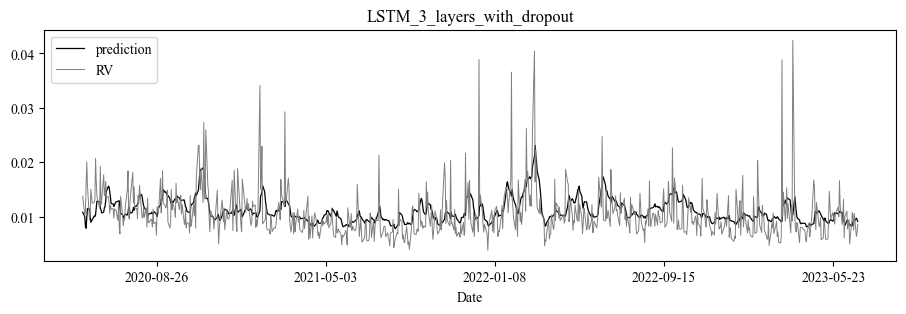

(0.0040008720179594585,
 0.045283018867924525,
 (0.2525184712865965, 0.5996471530895536))

In [26]:
#### Test function ####

# Select features
features = ['RV_1', 'RQ_1', 'VSMI']

df_train, df_test = create_df_selected_features (data, features)

# Test function
rmse, violation_ratio, dmw_test = lstm_3_layers_with_dropout(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                     neurons = [64,32,16], n_past = 50, batch_size = 32, dropout=0.1, plot = True)
rmse, violation_ratio, dmw_test

/Users/pietrobonazzi/miniconda3/envs/Python_Thesis_Env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 1s 14ms/step


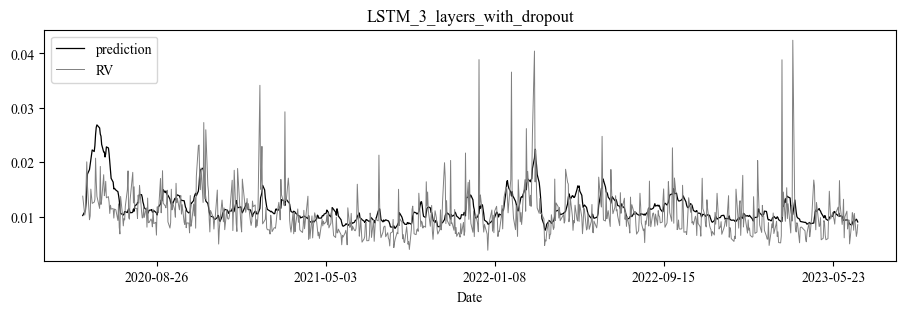

(0.0042199884747659835,
 0.04150943396226415,
 (-2.0948765836606276, 0.018249143321406373))

In [28]:
#### Test function ####

# Select features
features = ['RV_1', 'RQ_1', 'VSMI']

df_train, df_test = create_df_selected_features (data, features)

# Test function
rmse, violation_ratio, dmw_test = lstm_3_layers_with_dropout(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                     neurons = [64,64,64], n_past = 50, batch_size = 32, dropout=0.1, plot = True)
rmse, violation_ratio, dmw_test

In [34]:
def lstm_3_layers_with_dropout_nobidirectional(df_train, df_test, results_bmk, neurons = [32,16,8], n_past = 22, batch_size = 32, dropout = 0.1, plot = False): 

    '''
    LSTM 3 layers with dropout model without bidirectional layers.

    Parameters
    ----------
    df_train : pandas.DataFrame
        Train data.
    df_test : pandas.DataFrame
        Test data.
    results_bmk : pandas.DataFrame
        Results of the HAR benchmark model.
    neurons : list, optional    
        Number of neurons in the LSTM layers. The default is [32,16,8].
    n_past : int, optional  
        Number of past observations to use as input. The default is 22. 
    batch_size : int, optional  
        Batch size. The default is 32.  
    dropout : float, optional
        Dropout rate. The default is 0.1.
    plot : bool, optional
    '''

    np.random.seed(2024)
    n_dims = df_train.shape[1]-2
    x_train, y_train = windowed_dataset(df_train.drop(['Returns', 'RV'], axis=1), df_train['RV'], n_past)

    lstm = tf.keras.models.Sequential([ 
        tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
        tf.keras.layers.BatchNormalization(), 

        tf.keras.layers.LSTM(neurons[0], return_sequences=True),
        tf.keras.layers.Dropout(dropout),

        tf.keras.layers.LSTM(neurons[1], return_sequences=True),
        tf.keras.layers.Dropout(dropout),

        tf.keras.layers.LSTM(neurons[2]),
        tf.keras.layers.Dropout(dropout),

        tf.keras.layers.Dense(1)
    ])
    
    def rmse(y_true, y_pred):
        loss = backend.sqrt(backend.mean(backend.square((y_true - y_pred))))
        return loss

    lstm.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmse])
    
    checkpoint_cb = ModelCheckpoint('NN_models/lstm_2_layers_with_dropout_nobidirectional.h5',
                                save_best_only=True,
                                monitor='val_rmse')

    early_stopping_cb = EarlyStopping(patience=50,
                                  restore_best_weights=True,
                                  monitor='val_rmse')
    
    lstm_res = lstm.fit(x_train, y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.3, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=300)
    
    x_test, y_test = windowed_dataset(df_test.drop(['Returns', 'RV'], axis=1), df_test['RV'], n_past)
    x, returns = windowed_dataset(df_test.drop(['Returns', 'RV'], axis=1), df_test['Returns'], n_past)

    # Predictions
    pred = lstm.predict(x_test)
    df_results = pd.DataFrame({'RV': y_test, 'pred': pred.flatten(), 'returns': returns})
    df_results.index = df_test.index[n_past-1:]

    # Calculate the RMSE
    rmse = np.sqrt(mse(df_results['RV'], df_results['pred']))

    # Calculate the violation ratio
    alpha = 0.05
    var = pd.DataFrame({'VAR': df_results['pred']* norm.ppf(alpha), 'Returns': df_results['returns']})
    violation_ratio = (var['Returns'] < var['VAR']).sum()/len(df_results)

    # Calculate the Diebold-Mariano test
    df_dmw_test = pd.concat([results_bmk['pred_bmk'], df_results['pred'], df_results['RV']], axis=1).dropna()
    dmw_test = dm_test(df_dmw_test['RV'], df_dmw_test['pred_bmk'], df_dmw_test['pred'], one_sided=True)

    if plot == True:
        plt.rcParams["font.family"] = "Times New Roman"
        fig, ax = plt.subplots(figsize=(11, 3))
        ax.plot(df_results['pred'], label='prediction', color='black', linewidth=0.9)
        ax.plot(df_results['RV'], label='RV', color='grey', linewidth=0.7)
        ax.set_title('LSTM_3_layers_with_dropout_nobidirectional') 
        ax.legend(loc='upper left')
        ax.set_xlabel('Date')
        ax.xaxis.set_major_locator(plt.MaxNLocator(6))
        plt.show()

    return rmse, violation_ratio, dmw_test

/Users/pietrobonazzi/miniconda3/envs/Python_Thesis_Env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 1s 9ms/step


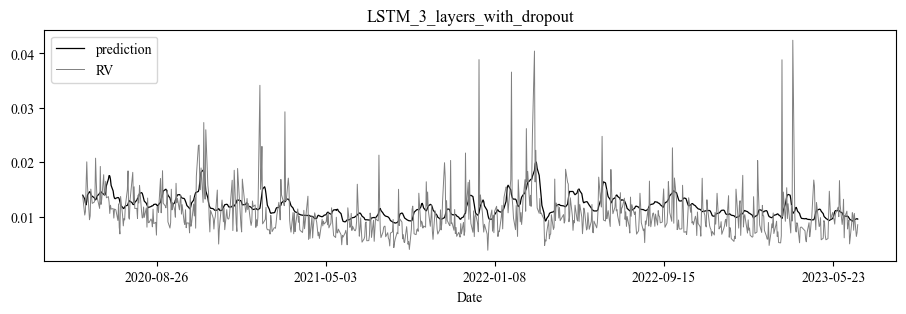

(0.004165629021227499,
 0.042767295597484274,
 (-2.1572402437334164, 0.01564317604013538))

In [30]:
#### Test function ####

# Select features
features = ['RV_1', 'RQ_1', 'VSMI']

df_train, df_test = create_df_selected_features (data, features)

# Test function
rmse, violation_ratio, dmw_test = lstm_3_layers_with_dropout_nobidirectional(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                     neurons = [64,64,64], n_past = 50, batch_size = 32, dropout=0.1, plot = True)
rmse, violation_ratio, dmw_test

/Users/pietrobonazzi/miniconda3/envs/Python_Thesis_Env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 1s 9ms/step


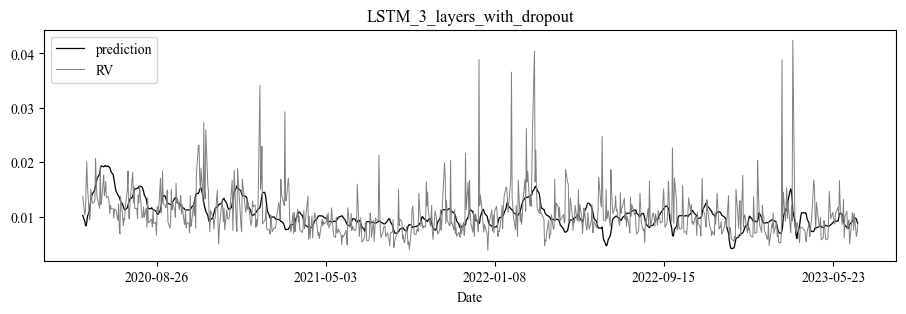

(0.004355932252010234,
 0.06037735849056604,
 (-4.906908557915783, 5.614524812631235e-07))

In [31]:
#### Test function ####

# Select features
features = ['RV_1', 'RQ_1', 'VSMI', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
        'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL',
        'NEWS_SENTIMENT_DAILY_AVG', 'CHFUSD', 'CHFEUR', 'GSWISS10', 'CCFASZE', 'SFSNTC', 'SSARON']

df_train, df_test = create_df_selected_features (data, features)

# Test function
rmse, violation_ratio, dmw_test = lstm_3_layers_with_dropout_nobidirectional(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                     neurons = [64,64,64], n_past = 50, batch_size = 32, dropout=0.1, plot = True)
rmse, violation_ratio, dmw_test

### MLP

In [41]:
def mlp_with_dropout(df_train, df_test, results_bmk, neurons = [32,16,8], n_past = 22, batch_size = 32, dropout = 0.1, plot = False): 

    '''
    MLP (multi layer perceptron) with dropout. 

    Parameters
    ----------
    df_train : pandas.DataFrame
        Train data.
    df_test : pandas.DataFrame
        Test data.
    results_bmk : pandas.DataFrame
        Results of the HAR benchmark model.
    neurons : list, optional
        Number of neurons in the MLP layers. The default is [32,16,8].
    n_past : int, optional
        Number of past observations to use as input. The default is 22.
    batch_size : int, optional
        Batch size. The default is 32.
    dropout : float, optional
        Dropout rate. The default is 0.1.
    plot : bool, optional
    ''' 

    np.random.seed(2024)
    n_dims = df_train.shape[1]-2
    x_train, y_train = windowed_dataset(df_train.drop(['Returns', 'RV'], axis=1), df_train['RV'], n_past)

    model = tf.keras.models.Sequential([

        tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
        tf.keras.layers.BatchNormalization(), 

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(neurons[0]),
        tf.keras.layers.Dropout(dropout),

        tf.keras.layers.Dense(neurons[1]),
        tf.keras.layers.Dropout(dropout),

        tf.keras.layers.Dense(neurons[2]),
        tf.keras.layers.Dropout(dropout),

        tf.keras.layers.Dense(1)
    ])


    def rmse(y_true, y_pred):
        loss = backend.sqrt(backend.mean(backend.square((y_true - y_pred))))
        return loss

    model.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmse])
    
    checkpoint_cb = ModelCheckpoint('NN_models/mlp_with_dropout.h5',
                                save_best_only=True,
                                monitor='val_rmse')

    early_stopping_cb = EarlyStopping(patience=100,
                                  restore_best_weights=True,
                                  monitor='val_rmse')
    
    lstm_res = model.fit(x_train, y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.3, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=300)
    
    x_test, y_test = windowed_dataset(df_test.drop(['Returns', 'RV'], axis=1), df_test['RV'], n_past)
    _, returns = windowed_dataset(df_test.drop(['Returns', 'RV'], axis=1), df_test['Returns'], n_past)

    # Predictions
    pred = model.predict(x_test)
    df_results = pd.DataFrame({'RV': y_test, 'pred': pred.flatten(), 'returns': returns})
    df_results.index = df_test.index[n_past-1:]

    # Calculate the RMSE
    rmse = np.sqrt(mse(df_results['RV'], df_results['pred']))

    # Calculate the violation ratio
    alpha = 0.05
    var = pd.DataFrame({'VAR': df_results['pred']* norm.ppf(alpha), 'Returns': df_results['returns']})
    violation_ratio = (var['Returns'] < var['VAR']).sum()/len(df_results)

    # Calculate the Diebold-Mariano test
    df_dmw_test = pd.concat([results_bmk['pred_bmk'], df_results['pred'], df_results['RV']], axis=1).dropna()
    dmw_test = dm_test(df_dmw_test['RV'], df_dmw_test['pred_bmk'], df_dmw_test['pred'], one_sided=True)

    if plot == True:
        plt.rcParams["font.family"] = "Times New Roman"
        fig, ax = plt.subplots(figsize=(11, 3))
        ax.plot(df_results['pred'], label='prediction', color='black', linewidth=0.9)
        ax.plot(df_results['RV'], label='RV', color='grey', linewidth=0.7)
        ax.set_title('MLP_with_dropout')
        ax.legend(loc='upper left')
        ax.set_xlabel('Date')
        ax.xaxis.set_major_locator(plt.MaxNLocator(6))
        plt.show()

    return rmse, violation_ratio, dmw_test

/Users/pietrobonazzi/miniconda3/envs/Python_Thesis_Env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 0s 404us/step


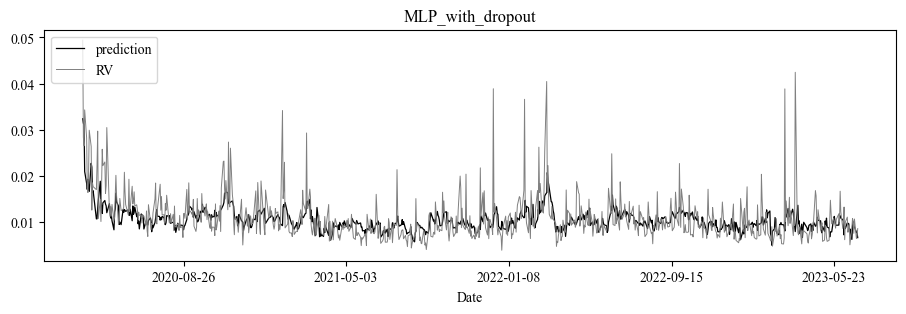

(0.004271564333310814,
 0.06181818181818182,
 (-1.6749219378358546, 0.04716448967330533))

In [36]:
#### Test function ####

# Select features
features = ['RV_1', 'RQ_1', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
        'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL']

df_train, df_test = create_df_selected_features (data, features)

# Test function
rmse, violation_ratio, dmw_test = mlp_with_dropout(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                     neurons = [32,32,32], n_past = 20, batch_size = 8, dropout=0.1, plot = True)
rmse, violation_ratio, dmw_test

/Users/pietrobonazzi/miniconda3/envs/Python_Thesis_Env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 0s 470us/step


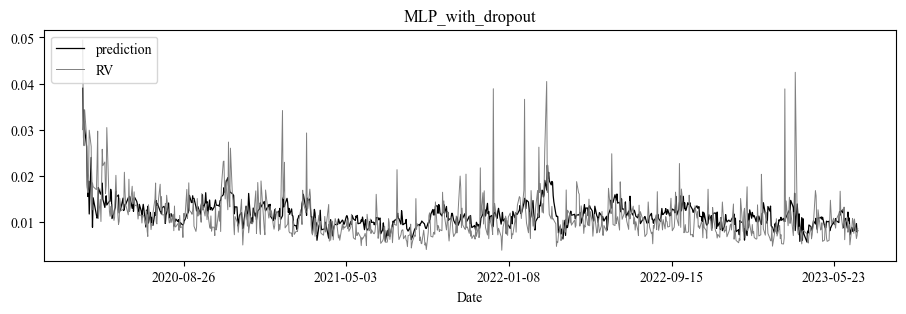

(0.004378275282376793,
 0.05090909090909091,
 (-2.5039631783324867, 0.006236678010121373))

In [38]:
#### Test function ####

# Select features
features = ['RV_1', 'RQ_1', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
        'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL']

df_train, df_test = create_df_selected_features (data, features)

# Test function
rmse, violation_ratio, dmw_test = mlp_with_dropout(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                     neurons = [32,32,32], n_past = 20, batch_size = 32, dropout=0.1, plot = True)
rmse, violation_ratio, dmw_test

/Users/pietrobonazzi/miniconda3/envs/Python_Thesis_Env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 0s 403us/step


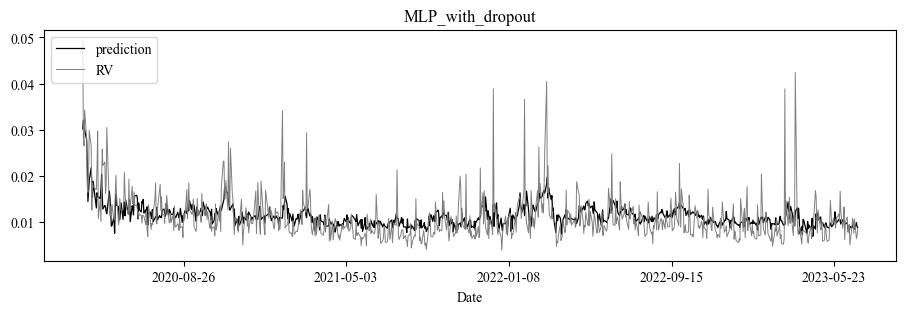

(0.004154383534868961,
 0.04363636363636364,
 (-0.08068491319908097, 0.46785606371297844))

In [43]:
#### Test function ####

# Select features
features = ['RV_1', 'RV_5', 'RV_22', 'RQ_1', 'RQ_5', 'RQ_22', 'VSMI']

df_train, df_test = create_df_selected_features (data, features)

# Test function
rmse, violation_ratio, dmw_test = mlp_with_dropout(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                     neurons = [10,10,10], n_past = 20, batch_size = 32, dropout=0.1, plot = True)
rmse, violation_ratio, dmw_test

/Users/pietrobonazzi/miniconda3/envs/Python_Thesis_Env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 0s 421us/step


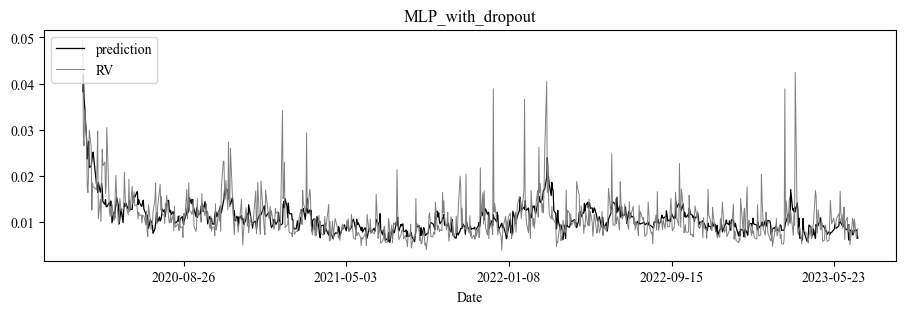

(0.004146686221209085,
 0.06060606060606061,
 (0.017690122967530166, 0.5070548287344037))

In [44]:
#### Test function ####

# Select features
features = ['RV_1', 'RV_5', 'RV_22', 'RQ_1', 'RQ_5', 'RQ_22', 'VSMI', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%']

df_train, df_test = create_df_selected_features (data, features)

# Test function
rmse, violation_ratio, dmw_test = mlp_with_dropout(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                     neurons = [10,10,10], n_past = 20, batch_size = 32, dropout=0.1, plot = True)
rmse, violation_ratio, dmw_test

### XGBoost

In [49]:
def xgboost(df_train, df_test, results_bmk, plot = False):

    # Define the model
    model = XGBRegressor(n_estimators=10000, learning_rate=0.001, random_state=2024)

    # Fit the model
    model.fit(df_train.drop(['Returns', 'RV'], axis=1), df_train['RV'])
    prediction = model.predict(df_test.drop(['Returns', 'RV'], axis=1))

    # Calculate the RMSE
    rmse = np.sqrt(mse(df_test['RV'], prediction))
    
    results = pd.DataFrame({'pred': prediction, 'RV': df_test['RV']})
    results.index = df_test.index


    # Calculate the violation ratio
    alpha = 0.05
    var = pd.DataFrame({'VAR': results['pred']* norm.ppf(alpha), 'Returns': df_test['Returns']})
    violation_ratio = (var['Returns'] < var['VAR']).sum()/len(df_test)


    # Calculate the Diebold-Mariano test
    df_dmw_test = pd.concat([results_bmk['pred_bmk'], results['pred'], df_test['RV']], axis=1)
    dmw_test = dm_test(df_dmw_test['RV'], df_dmw_test['pred_bmk'], df_dmw_test['pred'], one_sided=True)

    if plot is True:
        plt.rcParams["font.family"] = "Times New Roman"
        fig, ax = plt.subplots(figsize=(11, 3))
        ax.plot(results['pred'], label='prediction', color='black', linewidth=0.9)
        ax.plot(results['RV'], label='RV', color='grey', linewidth=0.7)
        ax.set_title('XGBoost')   
        ax.legend(loc='upper left')
        ax.set_xlabel('Date')
        ax.xaxis.set_major_locator(plt.MaxNLocator(6))
        plt.show()
    

    return rmse, violation_ratio, dmw_test

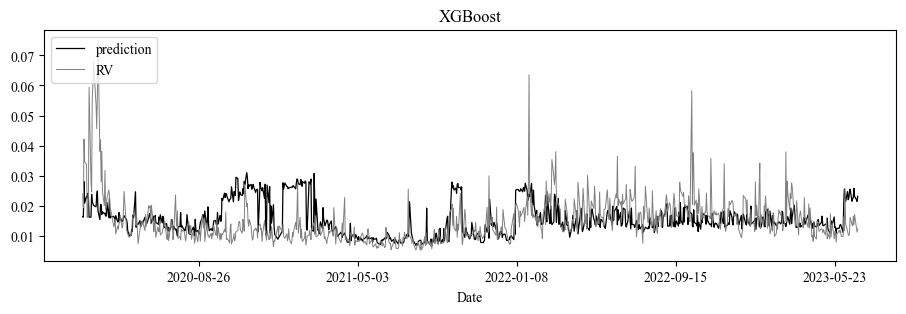

(0.008389339619707165,
 0.052132701421800945,
 (-8.798225807911464, 3.87677785982738e-18))

In [51]:
#### Test function ####

# Select features
features = ['RV_1', 'RV_5', 'RV_22']
#features = ['RV_1', 'RV_5', 'RV_22', 'RQ_1', 'RQ_5', 'RQ_22', 'VSMI', 'AVERAGE_BID_ASK_SPREAD_%', 'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL', 'NEWS_SENTIMENT_DAILY_AVG']
features = ['RV_1', 'RV_5', 'RV_22', 'RQ_1', 'RQ_5', 'RQ_22', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
                'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL','NEWS_SENTIMENT_DAILY_AVG', 'VSMI', 'CHFEUR', 'CHFUSD', 'SFSNTC', 'GSWISS10', 'CCFASZE', 'SSARON', 'EURCHFV3M', 'USDCHFV3M']
df_train, df_test = create_df_selected_features (data, features)

# Test function
rmse, violation_ratio, dmw_test = xgboost(df_train=df_train, df_test=df_test, results_bmk=results_bmk, plot = True)
rmse, violation_ratio, dmw_test